In [1]:
import sys; sys.path.insert(0, '../');
from ccqe_notebook_tools import *
import matplotlib.patches as patches
%matplotlib inline
# %matplotlib notebook

In [2]:
from IPython.core.display import HTML,display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
File = ROOT.TFile("/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TracksAnaFiles/Events_MCC7_MC_BNB_2TracksClusters.root")
# File = ROOT.TFile("/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TracksAnaFiles/Events_MCC7_ExampleDebugging_2TracksClusters.root")
tree = File.Get("TwoTracksTree")
events = AnalyzeVertex( tree )

In [14]:
def associate_hits_to_tracks(hits,tracks,max_hit_time_track_time_diff=10,
                             fontsize=20,figsize=(16,6),debug=0,
                             MCmode=True):
    '''
    input: the CC1p candidate tracks.
    
    returns: the ratio of charge associated with tracks to total charge in CCQE roi box
             averaged over 3 planes
    '''
    
    print 'track-1:',tracks[0].avg_dqdx,'ADC/cm',',',tracks[0].length*tracks[0].avg_dqdx,'ADC'
    print 'track-2:',tracks[1].avg_dqdx,'ADC/cm',',',tracks[1].length*tracks[1].avg_dqdx,'ADC'
#     print 'track-1:',tracks[0].tot_dqdx,'ADC/cm',',',tracks[0].length*tracks[0].tot_dqdx,'ADC'
#     print 'track-2:',tracks[1].tot_dqdx,'ADC/cm',',',tracks[1].length*tracks[1].tot_dqdx,'ADC'

    total_sum_hits_charge_in_ROI = 0
    sum_charge_both_tracks_all_planes = tracks[0].dQtotal + tracks[1].dQtotal
    if debug: print 'sum of charge in both tracks in all planes:',sum_charge_both_tracks_all_planes,'ADC'
    
    fig = plt.figure(figsize=figsize)
    fig2 = plt.figure(figsize=figsize)


    tracks_trajectories = dict()
    ratio_charge_associated_with_tracks_to_total_charge = [] # 3 ratios for 3 planes
    
    for plane in range(3):
        if debug: print 'plane:',plane
        ax = fig.add_subplot(1,3,plane+1)
        hit_wire , hit_time , hit_charge = [] , [] , []
        hits_charge_in_ROI , hits_charge_in_ROI_associated_with_tracks = [] , []
        hits_trajectory_time_diff = []
        
        associated_hit_wire , associated_hit_time = [] , [] 
        non_associated_hit_wire , non_associated_hit_time = [] , [] 

        # hits
        for hit in hits:
            if hit.hit_plane==plane:
                hit_wire.append(hit.hit_wire)
                hit_time.append(hit.hit_peakT)
                hit_charge.append(hit.hit_charge)
        ax.scatter(hit_wire,hit_time,c=hit_charge, vmin=np.min(hit_charge), vmax=np.max(hit_charge),cmap='hot_r')

        
        t_start_wire_min , t_end_wire_max = 8256 , 0
        t_start_time_min , t_end_time_max = 9500 , 0

        # build an ROI for the CC1p vertex
        for t in tracks:
            color, label = set_color_label(t.MCpdgCode,MCmode=MCmode)
            if plane==0:
                t_start_wire,t_start_time = t.start_wire_u, t.start_time_u
                t_end_wire,t_end_time = t.end_wire_u, t.end_time_u            
            elif plane==1:            
                t_start_wire,t_start_time = t.start_wire_v, t.start_time_v                
                t_end_wire,t_end_time = t.end_wire_v, t.end_time_v                
            elif plane==2:            
                t_start_wire,t_start_time = t.start_wire_y, t.start_time_y                
                t_end_wire,t_end_time = t.end_wire_y, t.end_time_y
            
            t_start_wire_min = np.min([t_start_wire , t_end_wire , t_start_wire_min])
            t_end_wire_max = np.max([t_start_wire , t_end_wire , t_end_wire_max])
            t_start_time_min = np.min([t_start_time , t_end_time , t_start_time_min])
            t_end_time_max = np.max([t_start_time , t_end_time , t_end_time_max])

            
            
            t_slope = float(t_end_time-t_start_time)/(t_end_wire-t_start_wire) if t_end_wire!=t_start_wire else 1000
            t_intersect = t_end_time - t_slope*t_end_wire
            tracks_trajectories['t %d plane %d start-wire'%(t.track_id,plane)] = t_start_wire
            tracks_trajectories['t %d plane %d start-time'%(t.track_id,plane)] = t_start_time
            tracks_trajectories['t %d plane %d end-wire'%(t.track_id,plane)] = t_end_wire
            tracks_trajectories['t %d plane %d end-time'%(t.track_id,plane)] = t_end_time
            tracks_trajectories['t %d plane %d slope'%(t.track_id,plane)] = t_slope
            tracks_trajectories['t %d plane %d intersect'%(t.track_id,plane)] = t_intersect
            
            ax.plot( [t_start_wire,t_end_wire] , [t_start_time,t_end_time] ,label='track %d '%t.track_id+label, color=color,alpha=0.4)
            ax.set_title('%s plane'%('u' if plane==0 else 'v' if plane==1 else 'y'),y=0.95)
        
        for hit_w,hit_t,hit_c in zip(hit_wire,hit_time,hit_charge):
            if t_start_wire_min < hit_w and hit_w < t_end_wire_max and t_start_time_min < hit_t and hit_t < t_end_time_max :
                if debug>2: print 'hit in ROI: (wire=%d,time=%d) '%(hit_w,hit_t)
                
                hits_charge_in_ROI.append( hit_c )
                
                for t in tracks:
                    min_wire = np.min([tracks_trajectories['t %d plane %d start-wire'%(t.track_id,plane)], tracks_trajectories['t %d plane %d end-wire'%(t.track_id,plane)] ] )
                    max_wire = np.max([tracks_trajectories['t %d plane %d start-wire'%(t.track_id,plane)], tracks_trajectories['t %d plane %d end-wire'%(t.track_id,plane)] ] )
                    min_time = np.min([tracks_trajectories['t %d plane %d start-time'%(t.track_id,plane)], tracks_trajectories['t %d plane %d end-time'%(t.track_id,plane)] ])
                    max_time = np.max([tracks_trajectories['t %d plane %d start-time'%(t.track_id,plane)], tracks_trajectories['t %d plane %d end-time'%(t.track_id,plane)] ])

                    if debug>2: print t.track_id,[min_wire, max_wire],[min_time, max_time]
                        
                    if  min_wire < hit_w and hit_w < max_wire and  min_time < hit_t and hit_t < max_time:

                        slope = tracks_trajectories['t %d plane %d slope'%(t.track_id,plane)] 
                        intersect = tracks_trajectories['t %d plane %d intersect'%(t.track_id,plane)]
                        time_along_track = float( slope*hit_w + intersect ) 
                        
                        hit_time_track_time_diff = hit_t - time_along_track
                        if debug>2:
                            print 'track ', t.track_id ,'time along trajectory: ',time_along_track
                            print 'hit time: ',hit_t 
                            print 'difference in times: ',hit_time_track_time_diff
                        hits_trajectory_time_diff.append(hit_time_track_time_diff)
                        
                        if np.abs(hit_time_track_time_diff) < max_hit_time_track_time_diff:
                            if debug>2: print 'associating hit',hit_w,hit_t,'with track',t.track_id,'charge',hit_c
                            hits_charge_in_ROI_associated_with_tracks.append( hit_c )
                            associated_hit_wire.append(hit_w)
                            associated_hit_time.append(hit_t)

                        else: 
                            non_associated_hit_wire.append(hit_w)
                            non_associated_hit_time.append(hit_t)
                            if debug>2: print 'not associating hit',hit_w,hit_t,'with track',t.track_id,'charge',hit_c

                            
        sum_hits_charge_in_ROI = np.sum(hits_charge_in_ROI)
        total_sum_hits_charge_in_ROI += sum_hits_charge_in_ROI
        sum_hits_charge_in_ROI_associated_with_tracks = np.sum(hits_charge_in_ROI_associated_with_tracks)
        ratio_charge_associated_with_tracks_to_total_charge.append( sum_hits_charge_in_ROI_associated_with_tracks/sum_hits_charge_in_ROI ) if sum_hits_charge_in_ROI>0 else 0
        
        if debug: 
            print 'sum of hits-charge in ROI:',sum_hits_charge_in_ROI
            print 'sum of hits-charge in ROI associated with tracks:',sum_hits_charge_in_ROI_associated_with_tracks
            print 'ratio of charge associated with tracks to total charge:',ratio_charge_associated_with_tracks_to_total_charge
        
        # CC1p ROI
        ax.add_patch( patches.Rectangle( (t_start_wire_min, t_start_time_min), (t_end_wire_max-t_start_wire_min) , (t_end_time_max-t_start_time_min) ,fill=False) )
        ax.set_xlim( t_start_wire_min - 10 , t_end_wire_max + 10 )
        ax.set_ylim( t_start_time_min - 10 , t_end_time_max + 10 )
        # drift velocity is 0.160 cm/us

        ax.xaxis.set_major_locator(LinearLocator(4));ax.yaxis.set_major_locator(LinearLocator(4))
        set_axes(ax,x_label='wire',y_label='peak-time' if plane==0 else '',fontsize=fontsize)
        if plane!=0: ax.yaxis.set_major_formatter( NullFormatter() )
        if MCmode and plane==0: ax.legend(loc='best',fontsize=fontsize)
        if debug>1:
            ax.scatter(associated_hit_wire,associated_hit_time,c='blue')
            ax.scatter(non_associated_hit_wire,non_associated_hit_time,c='red')



            
        ax2 = fig2.add_subplot(1,3,plane+1)
        h,bins,_=ax2.hist(hits_trajectory_time_diff,bins=np.linspace(np.min(hits_trajectory_time_diff),np.max(hits_trajectory_time_diff),60));
        set_axes(ax2,x_label='$\\Delta t (trajectory-hit)$ [ns]',y_label='') 
        plt.text(np.min(hits_trajectory_time_diff) + 5,0.8*np.max(h),'mean=%.2f'%(np.mean(hits_trajectory_time_diff)),fontsize=fontsize)
        plt.text(np.min(hits_trajectory_time_diff) + 5,0.7*np.max(h),'std.=%.2f'%(np.std(hits_trajectory_time_diff)),fontsize=fontsize)

        ax2.xaxis.set_major_locator(LinearLocator(4));ax2.yaxis.set_major_locator(LinearLocator(4))
        if plane!=0: ax2.yaxis.set_major_formatter( NullFormatter() )
    plt.tight_layout()

    ratio_tracks_tot_dqdx_to_total_charge = sum_charge_both_tracks_all_planes/total_sum_hits_charge_in_ROI
    return np.average(ratio_charge_associated_with_tracks_to_total_charge), ratio_tracks_tot_dqdx_to_total_charge

In [108]:
def associate_closest_hits_to_tracks(hits,tracks,                      
                                     fontsize=20,figsize=(16,6),debug=0,
                                     MCmode=True):
    '''
    input: the CC1p candidate tracks.
    
    returns: the ratio of charge associated with tracks to total charge in CCQE roi box
             averaged over 3 planes
    '''
    fig = plt.figure(figsize=figsize)    
    tracks_trajectories = dict()
    ratio_charge_associated_to_charge_total = []

    for plane in range(3):        
        ax = fig.add_subplot(1,3,plane+1)
        
        t_start_wire_min , t_end_wire_max , t_start_time_min , t_end_time_max= 8256 , 0 , 9500 , 0
        hit_wire, hit_time, hit_charge = [] , [] , []
        associated_hit_wire, associated_hit_time, associated_hit_charge = [] , [] , []

        # hits in this plane
        for hit in hits:
            if hit.hit_plane==plane:
                hit_wire.append(hit.hit_wire)
                hit_time.append(hit.hit_peakT)
                hit_charge.append(hit.hit_charge)

        # loop over the tracks,
        # and associate the closest hit to each track to this track        
        for t in tracks:
            color, label = set_color_label(t.MCpdgCode,MCmode=MCmode)
            if plane==0:
                t_start_wire,t_start_time = t.start_wire_u, t.start_time_u
                t_end_wire,t_end_time = t.end_wire_u, t.end_time_u            
            elif plane==1:            
                t_start_wire,t_start_time = t.start_wire_v, t.start_time_v                
                t_end_wire,t_end_time = t.end_wire_v, t.end_time_v                
            elif plane==2:            
                t_start_wire,t_start_time = t.start_wire_y, t.start_time_y                
                t_end_wire,t_end_time = t.end_wire_y, t.end_time_y            
            t_start_wire_min = np.min([t_start_wire , t_end_wire , t_start_wire_min])
            t_end_wire_max = np.max([t_start_wire , t_end_wire , t_end_wire_max])
            t_start_time_min = np.min([t_start_time , t_end_time , t_start_time_min])
            t_end_time_max = np.max([t_start_time , t_end_time , t_end_time_max])            
            
            t_slope = float(t_end_time-t_start_time)/(t_end_wire-t_start_wire) if t_end_wire!=t_start_wire else 1000
            t_intersect = t_end_time - t_slope*t_end_wire        
            min_wire = np.min( [t_start_wire,t_end_wire] ) - 0
            max_wire = np.max( [t_start_wire,t_end_wire] ) + 0
            min_time = np.min( [t_start_time,t_end_time] ) - 0
            max_time = np.max( [t_start_time,t_end_time] ) + 0


            # hits - find the vertical distance to each of the tracks
            # and the closest vertically
            # for each wire - we associate only one hit to each track
            for wire in range(t_start_wire_min,t_end_wire_max): #{
                hit_track_vertical_distance_min = 10000
                t_hit_associated_in_wire = None
                
                for i_hit,hit in enumerate(hits): #{
                    if hit.hit_plane==plane and hit.hit_wire==wire: #{
                        if min_wire < hit.hit_wire and hit.hit_wire < max_wire and min_time < hit.hit_peakT and hit.hit_peakT < max_time: #{
                            time_along_track = t_slope*hit.hit_wire + t_intersect 
                            hit_track_vertical_distance = np.abs(hit.hit_peakT - time_along_track)
                            if (hit_track_vertical_distance < hit_track_vertical_distance_min): #{
                                hit_track_vertical_distance_min = hit_track_vertical_distance
                                t_hit_associated_in_wire = hit 
                if t_hit_associated_in_wire is not None:#{
                    associated_hit_wire.append(t_hit_associated_in_wire.hit_wire)
                    associated_hit_time.append(t_hit_associated_in_wire.hit_peakT)
                    associated_hit_charge.append(t_hit_associated_in_wire.hit_charge)
                #}
            #}

#             for time in np.arange(t_start_time_min,t_end_time_max,0.5): #{
#                 hit_track_horizontal_distance_min = 10000
#                 t_hit_associated_in_time = None                
#                 for i_hit,hit in enumerate(hits): #{
#                     if hit.hit_plane==plane and np.abs(hit.hit_peakT-time)<0.5: #{
#                         if min_wire < hit.hit_wire and hit.hit_wire < max_wire and min_time < hit.hit_peakT and hit.hit_peakT < max_time: #{
#                             wire_along_track = (hit.hit_peakT - t_intersect)/t_slope 
#                             hit_track_horizontal_distance = np.abs(hit.hit_wire - wire_along_track)
#                             if (hit_track_horizontal_distance < hit_track_horizontal_distance_min): #{
#                                 hit_track_horizontal_distance_min = hit_track_horizontal_distance
#                                 t_hit_associated_in_time = hit 


#                             #}
#                         #}
#                     #}
#                 #}
#             #}
#                 if t_hit_associated_in_time is not None:#{
#                     associated_hit_wire.append(t_hit_associated_in_time.hit_wire)
#                     associated_hit_time.append(t_hit_associated_in_time.hit_peakT)
#                     associated_hit_charge.append(t_hit_associated_in_time.hit_charge)
#                 #}
#             #}
                        
            ax.plot( [t_start_wire,t_end_wire] , [t_start_time,t_end_time] ,label='track %d '%t.track_id+label, color=color,alpha=0.4)

        ax.scatter(hit_wire,hit_time,c=hit_charge, vmin=np.min(hit_charge), vmax=np.max(hit_charge),cmap='hot_r')
        ax.scatter(associated_hit_wire,associated_hit_time,c='blue')
        ax.set_title('%s plane'%('u' if plane==0 else 'v' if plane==1 else 'y'),y=0.95)
                
        # CC1p ROI
        ax.add_patch( patches.Rectangle( (t_start_wire_min, t_start_time_min), (t_end_wire_max-t_start_wire_min) , (t_end_time_max-t_start_time_min) ,fill=False) )
        ax.set_xlim( t_start_wire_min - 8 , t_end_wire_max + 16 )
        ax.set_ylim( t_start_time_min - 8 , t_end_time_max + 16 )
        ax.xaxis.set_major_locator(LinearLocator(4));ax.yaxis.set_major_locator(LinearLocator(4))
        set_axes(ax,x_label='wire',y_label='peak-time' if plane==0 else '',fontsize=fontsize)
        if plane!=0: ax.yaxis.set_major_formatter( NullFormatter() )
        if MCmode and plane==0: ax.legend(loc='best',fontsize=fontsize)

        
        sum_hit_charge = np.sum(hit_charge)
        sum_associated_hit_charge = np.sum(associated_hit_charge)
        ratio_charge_associated_to_charge_total.append(sum_associated_hit_charge/sum_hit_charge)
        if debug:
            print 'plane',plane 
            print 'sum_hit_charge:',sum_hit_charge
            print 'sum_associated_hit_charge:',sum_associated_hit_charge

    print ratio_charge_associated_to_charge_total
    return np.average(ratio_charge_associated_to_charge_total)

In [300]:
def plot_hits(hits,plane,ax=None):
    hit_wire, hit_time, hit_charge = [] , [] , []
    # hits in this plane
    for hit in hits:
        if hit.hit_plane==plane:
            hit_wire.append(hit.hit_wire)
            hit_time.append(hit.hit_peakT)
            hit_charge.append(hit.hit_charge)
    if ax is not None:
        ax.scatter(hit_wire,hit_time,c=hit_charge, vmin=np.min(hit_charge), vmax=np.max(hit_charge),cmap='hot_r')
    return hit_wire, hit_time, hit_charge

In [307]:
def get_t_start_end(t,plane): # t is a track
    if plane==0:    
        t_start_wire,t_start_time = t.start_wire_u, t.start_time_u                
        t_end_wire,t_end_time = t.end_wire_u, t.end_time_u
    elif plane==1:                
        t_start_wire,t_start_time = t.start_wire_v, t.start_time_v                                    
        t_end_wire,t_end_time = t.end_wire_v, t.end_time_v                
    elif plane==2:                            
        t_start_wire,t_start_time = t.start_wire_y, t.start_time_y                                    
        t_end_wire,t_end_time = t.end_wire_y, t.end_time_y            
    return t_start_wire , t_start_time , t_end_wire , t_end_time

In [308]:
def closest_track_to_hit(plane,hit,tracks):
    min_distance , closest_track_id = 10000 , -100
    for track in tracks:
        # point-line distance [http://mathworld.wolfram.com/Point-LineDistance2-Dimensional.html]
        x1 , y1 , x2 , y2 = get_t_start_end(track,plane)
        x0 , y0 = hit.hit_wire , hit.hit_peakT
        distance_track_hit = np.abs(float((x2-x1)*(y1-y0) - (x1-x0)*(y2-y1)))/np.sqrt(np.square(x2-x1) + np.square(y2-y1) )
        if distance_track_hit < min_distance:
            min_distance = distance_track_hit
            closest_track_id = track.track_id
    return closest_track_id

In [326]:
# tracking
def find_next_hit_in_track(plane,current_hit,
                           hits_not_yet_seen,
                           tracks,
                           this_track_id,
                           distance_threshold=300,
                           track_slope=0,track_intersept=0,
                           vertical_distance_threshold=2000):
    distace_to_next_hit = distance_threshold
    next_hit = None            
    for hit in hits_not_yet_seen:        
        if hit.hit_plane == plane:
            distace_to_hit = np.sqrt( np.square(current_hit.hit_wire-hit.hit_wire) + np.square(current_hit.hit_peakT-hit.hit_peakT) )
            time_along_track = track_slope*hit.hit_wire + track_intersept
            vertical_distance_to_track = np.abs(hit.hit_peakT - time_along_track)
            
            if distace_to_hit < distace_to_next_hit and closest_track_to_hit(plane,hit,tracks)==this_track_id and vertical_distance_to_track < vertical_distance_threshold:
                distace_to_next_hit = distace_to_hit
                next_hit = hit                
    return next_hit

In [327]:
def find_track_from_hit(plane , start_hit, hits , box ,                            
                        tracks,
                        this_track_id,
                        track_slope , track_intersept):
    [ min_wire , max_wire , min_time , max_time ] = box 
    track_hits_wire = []
    track_hits_time = []
    track_hits_charge = []
    hits_not_yet_seen = []
    current_hit = start_hit
    for hit in hits:
        if min_wire<hit.hit_wire and hit.hit_wire<max_wire and min_time<hit.hit_peakT and hit.hit_peakT<max_time:            
            hits_not_yet_seen.append(hit)
            
    for i in range(1000):

        track_hits_wire.append(current_hit.hit_wire)
        track_hits_time.append(current_hit.hit_peakT)
        track_hits_charge.append(current_hit.hit_charge)        
        next_hit = find_next_hit_in_track( plane=plane , current_hit=current_hit
                                          , tracks=tracks
                                          , this_track_id=this_track_id
                                          , hits_not_yet_seen=hits_not_yet_seen
                                          , track_slope=track_slope
                                          , track_intersept=track_intersept )
        if next_hit is not None:
            current_hit = next_hit
            hits_not_yet_seen.remove(next_hit)
        else:            
            break
    return track_hits_wire , track_hits_time , track_hits_charge , hits_not_yet_seen

In [ ]:
def find_my_track(plane,hits,box, track_slope , track_intersept,                        
                  tracks,this_track_id):
    
    [ min_wire , max_wire , min_time , max_time ] = box 
#     print box
    # find the closest hit to start point of the track
    distace_closest_hit_to_start = 10000
    closest_hit_to_start = None
    for hit in hits:
        start_time = track_slope*min_wire+track_intersept
        distace_to_hit = np.sqrt( np.square(min_wire-hit.hit_wire) + np.square(start_time-hit.hit_peakT) )
        if distace_to_hit < distace_closest_hit_to_start:
            distace_closest_hit_to_start = distace_to_hit
            closest_hit_to_start = hit 
#     print closest_hit_to_start.hit_wire,closest_hit_to_start.hit_peakT
    # perform the tracking from this point
    if closest_hit_to_start is not None:
        track_hits_wire , track_hits_time , track_hits_charge , hits_not_yet_seen = find_track_from_hit(plane=plane
                                                                                                        ,start_hit=closest_hit_to_start
                                                                                                        ,hits=hits
                                                                                                        ,tracks=tracks
                                                                                                        ,this_track_id=this_track_id
                                                                                                        ,box=box
                                                                                                        ,track_slope=track_slope 
                                                                                                        ,track_intersept=track_intersept)
        return track_hits_wire , track_hits_time , track_hits_charge , hits_not_yet_seen

In [322]:
def perform_tracking(hits,tracks,planes=[0,1,2],                  
                     fontsize=20,figsize=(16,6),debug=0,                     
                     MCmode=True):
    ratio_charge_per_plane = [] 
    t1_hits, t2_hits = [] , []
    my_tracks , tracks_boxes = [] , []
    for plane in planes:        
        
        t_start_wire_min , t_end_wire_max , t_start_time_min , t_end_time_max= 8256 , 0 , 9500 , 0
        hit_wire, hit_time, hit_charge = plot_hits(hits,plane)
        charge_per_plane = np.sum(hit_charge) 
        charge_from_tracks_per_plane = 0
                
        for t in tracks:
            color, label = set_color_label(t.MCpdgCode,MCmode=MCmode)
            t_start_wire , t_start_time , t_end_wire , t_end_time = get_t_start_end(t,plane)
            t_start_wire_min = np.min([t_start_wire , t_end_wire , t_start_wire_min])
            t_end_wire_max = np.max([t_start_wire , t_end_wire , t_end_wire_max])
            t_start_time_min = np.min([t_start_time , t_end_time , t_start_time_min])
            t_end_time_max = np.max([t_start_time , t_end_time , t_end_time_max])            
            
            min_wire , max_wire = np.min( [t_start_wire,t_end_wire] ) - 5 , np.max( [t_start_wire,t_end_wire] ) + 5
            min_time , max_time = np.min( [t_start_time,t_end_time] ) - 5 , np.max( [t_start_time,t_end_time] ) + 5
            box = [ min_wire , max_wire , min_time , max_time ]

            track_slope = float(t_end_time-t_start_time)/(t_end_wire-t_start_wire) if t_end_wire!=t_start_wire else 1000
#             print track_slope
            track_intersept = t_end_time - track_slope*t_end_wire        
#             print track_intersept
#             print '\n----\nperforming tracking for track',t.track_id
            my_track_hits_wire , my_track_hits_time , my_track_hits_charge , my_track_hits = find_my_track(plane=plane
                                                                                                           ,hits=hits
                                                                                                           ,box=box
                                                                                                           ,tracks=tracks
                                                                                                           ,this_track_id=t.track_id
                                                                                                           ,track_slope=track_slope , track_intersept= track_intersept)
            my_track = [plane , my_track_hits_wire , my_track_hits_time , my_track_hits_charge , color ]
            my_tracks.append(my_track)
#             print 'len(my_track_hits_wire):',len(my_track_hits_wire)
        charge_from_tracks_per_plane += np.sum(my_track_hits_charge)
        
        ratio_charge_per_plane.append( charge_from_tracks_per_plane/charge_per_plane )
    print ratio_charge_per_plane

    fig = plt.figure(figsize=figsize)    

    for plane in planes:
        ax = fig.add_subplot(1,3,plane+1)
        hit_wire, hit_time, hit_charge = plot_hits(hits=hits,plane=plane,ax=ax)
        t_start_wire_min , t_end_wire_max , t_start_time_min , t_end_time_max= 8256 , 0 , 9500 , 0

        for t in tracks:
            if plane==0:
                t_start_wire,t_start_time = t.start_wire_u, t.start_time_u
                t_end_wire,t_end_time = t.end_wire_u, t.end_time_u            
            elif plane==1:            
                t_start_wire,t_start_time = t.start_wire_v, t.start_time_v                
                t_end_wire,t_end_time = t.end_wire_v, t.end_time_v                
            elif plane==2:            
                t_start_wire,t_start_time = t.start_wire_y, t.start_time_y                
                t_end_wire,t_end_time = t.end_wire_y, t.end_time_y            
            t_start_wire_min = np.min([t_start_wire , t_end_wire , t_start_wire_min])
            t_end_wire_max = np.max([t_start_wire , t_end_wire , t_end_wire_max])
            t_start_time_min = np.min([t_start_time , t_end_time , t_start_time_min])
            t_end_time_max = np.max([t_start_time , t_end_time , t_end_time_max])
            color, label = set_color_label(t.MCpdgCode,MCmode=MCmode)
            ax.plot( [t_start_wire,t_end_wire] , [t_start_time,t_end_time] ,label='track %d '%t.track_id+label, color=color,alpha=0.5)

        for my_track in my_tracks:
            if my_track[0]==plane:
                ax.scatter(my_track[1],my_track[2],c=my_track[4])
        ax.set_title('%s plane'%('u' if plane==0 else 'v' if plane==1 else 'y'),y=0.95)
                
        # CC1p ROI
        ax.add_patch( patches.Rectangle( (t_start_wire_min, t_start_time_min), (t_end_wire_max-t_start_wire_min) , (t_end_time_max-t_start_time_min) ,fill=False) )
        ax.set_xlim( t_start_wire_min - 8 , t_end_wire_max + 8 )
        ax.set_ylim( t_start_time_min - 20 , t_end_time_max + 20 )
        ax.xaxis.set_major_locator(LinearLocator(4));ax.yaxis.set_major_locator(LinearLocator(4))
        set_axes(ax,x_label='wire',y_label='peak-time' if plane==0 else '',fontsize=fontsize)
        if plane!=0: ax.yaxis.set_major_formatter( NullFormatter() )
        if MCmode and plane==0: ax.legend(loc='best',fontsize=fontsize)

    return np.average(ratio_charge_per_plane)

a true CC1p
[0.66457397892595949, 0.68314575041589376, 0.6920176473535935]
0.679912458898


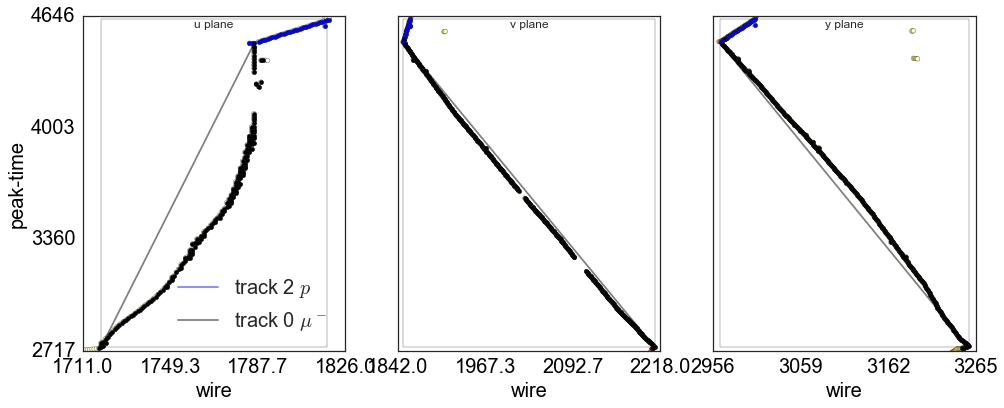

In [323]:
print 'a true CC1p'
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=4 , subrun=4255 , event=85085)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
# ratio = associate_hits_to_tracks( hits, tracks , debug=2, max_hit_time_track_time_diff=80)
ratio = perform_tracking(hits,tracks,debug=1,planes=[0,1,2])
# ratio = associate_closest_hits_to_tracks( hits, tracks , debug=2 )
print ratio

a true CC1p
[0.57912723510450537, 0.48171412914045891, 0.45890075846701367]
0.506580707571


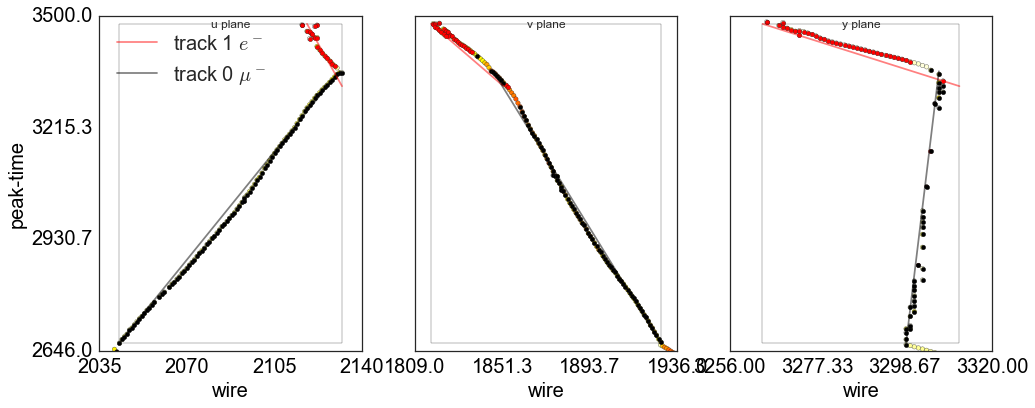

In [324]:
print 'a true CC1p'
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=1 , subrun=2287 , event=45725)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
# ratio = associate_hits_to_tracks( hits, tracks , debug=2, max_hit_time_track_time_diff=80)
ratio = perform_tracking( hits, tracks , debug=2 )
# perform_tracking( hits, tracks , debug=2 )
print ratio

not a true CC1p
Np,Nn,Npi: 2 0 1
[0.055738104438163266, 0.091497673402255356, 0.085258653848452062]
0.0774981438963


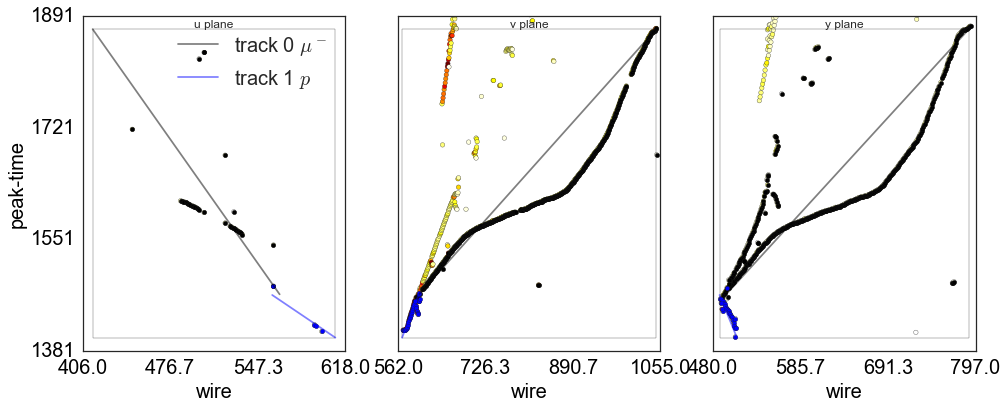

In [325]:
print 'not a true CC1p'
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=5 , subrun=5752 , event=115039)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
# ratio = associate_hits_to_tracks( hits, tracks , debug=2, max_hit_time_track_time_diff=80)
print 'Np,Nn,Npi:',vertex.closest_genie_interaction.Np,vertex.closest_genie_interaction.Nn,vertex.closest_genie_interaction.Npi
ratio = perform_tracking( hits, tracks , debug=2,planes=[0,1,2])
print ratio



[0.47521502763896234, 0.28965470560150153, 0.44278909286330237]
Np,Nn,Npi: 1 6 0
0.402552942035


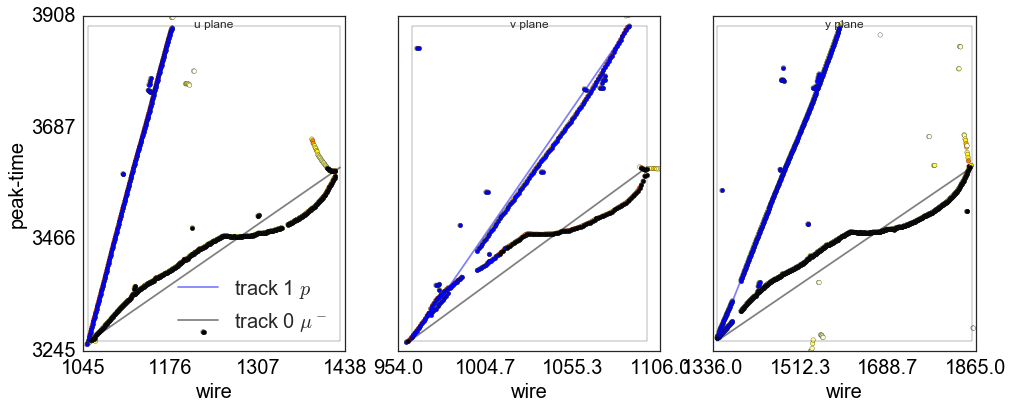

In [321]:
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=5 , subrun=2916 , event=58319)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
# ratio = associate_hits_to_tracks( hits, tracks , debug=2, max_hit_time_track_time_diff=80)
# ratio = associate_closest_hits_to_tracks( hits, tracks , debug=2)
ratio = perform_tracking( hits, tracks , debug=2)
print 'Np,Nn,Npi:',vertex.closest_genie_interaction.Np,vertex.closest_genie_interaction.Nn,vertex.closest_genie_interaction.Npi
print ratio

In [ ]:
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=5 , subrun=2059 , event=41161)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
ratio = associate_hits_to_tracks( hits, tracks , debug=1, max_hit_time_track_time_diff=80)
print ratio

sum of charge in both tracks in all planes: 66369.2662039 ADC
plane: 0
sum of hits-charge in ROI: 67832.5808067
sum of hits-charge in ROI associated with tracks: 66392.9389572
ratio of charge associated with tracks to total charge: [0.97877654318328777]
plane: 1
sum of hits-charge in ROI: 67346.2787137
sum of hits-charge in ROI associated with tracks: 41903.7736683
ratio of charge associated with tracks to total charge: [0.97877654318328777, 0.62221364667269874]
plane: 2
sum of hits-charge in ROI: 65671.9670258
sum of hits-charge in ROI associated with tracks: 64874.888382
ratio of charge associated with tracks to total charge: [0.97877654318328777, 0.62221364667269874, 0.98786272621488236]
(0.86295097202362292, 0.33044059287756805)


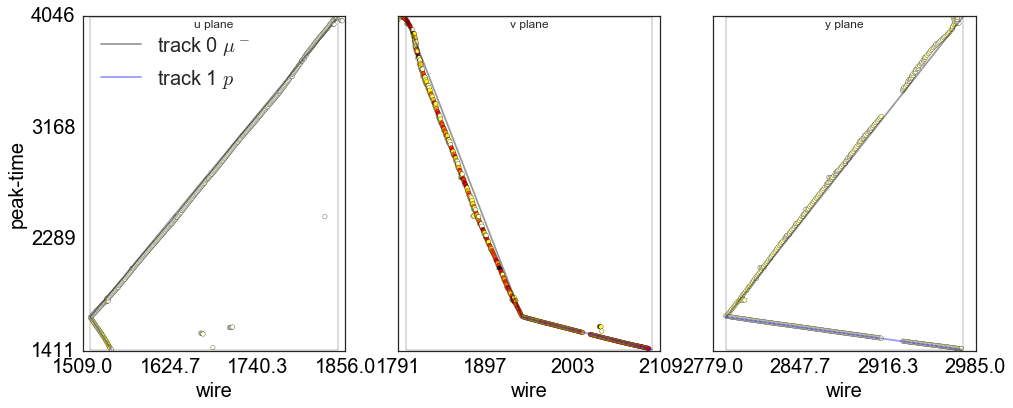

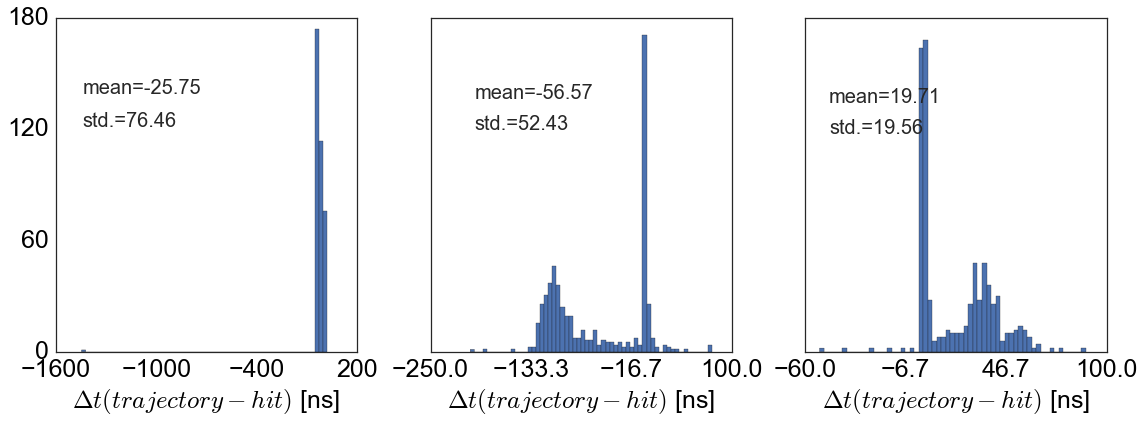

In [36]:
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=5 , subrun=2137 , event=42731)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
ratio = associate_hits_to_tracks( hits, tracks , debug=1, max_hit_time_track_time_diff=80)
print ratio

# using events-tree

In [3]:
File = ROOT.TFile("/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TracksAnaFiles/Events_MCC7_MC_BNB_AnalysisTrees.root")
tree = File.Get("eventsTree")
events = calcEventTopologies( tree )

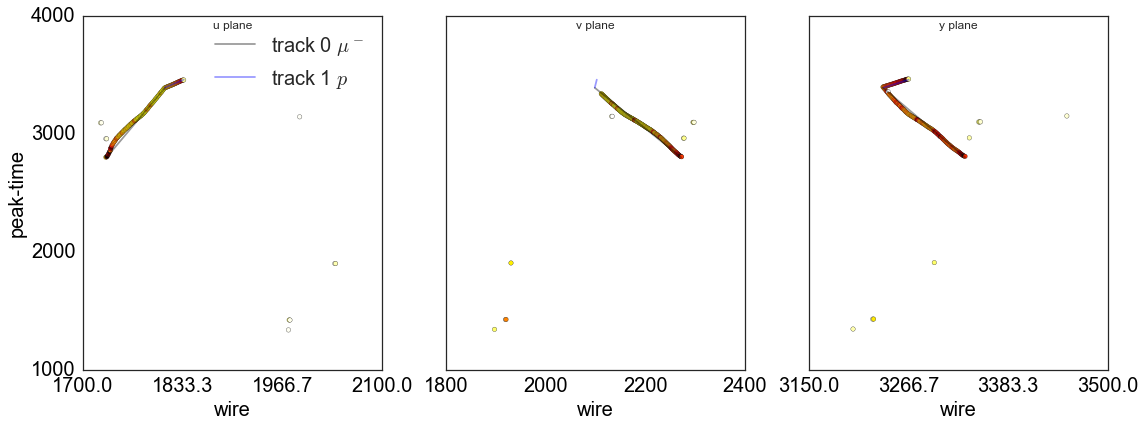

In [4]:
hits, tracks = get_event_from_rse(  events=events, run=4 , subrun=8805 , event=176092 )
draw_evd_tracks(hits, tracks,MCmode=True, vertex_x=[144.507000],vertex_y=[51.018800],vertex_z=[971.405000])

0.43111216447864675

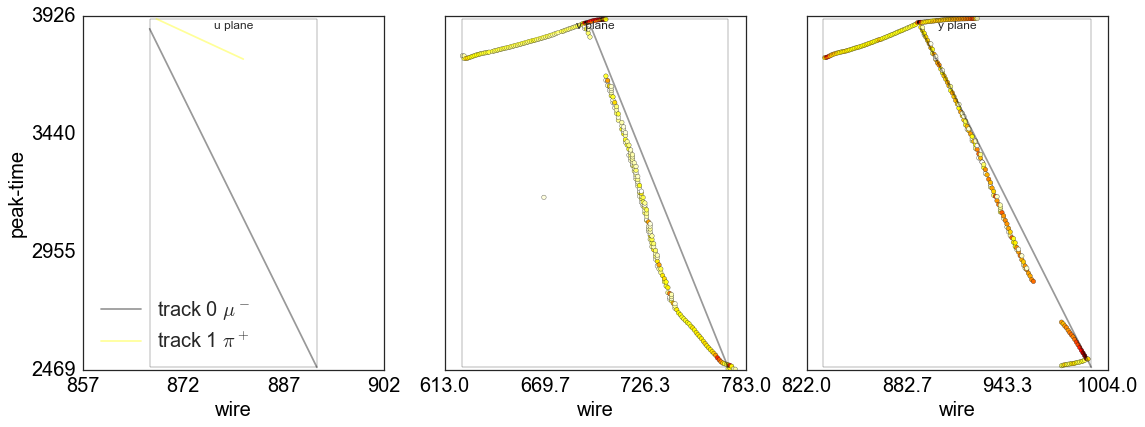

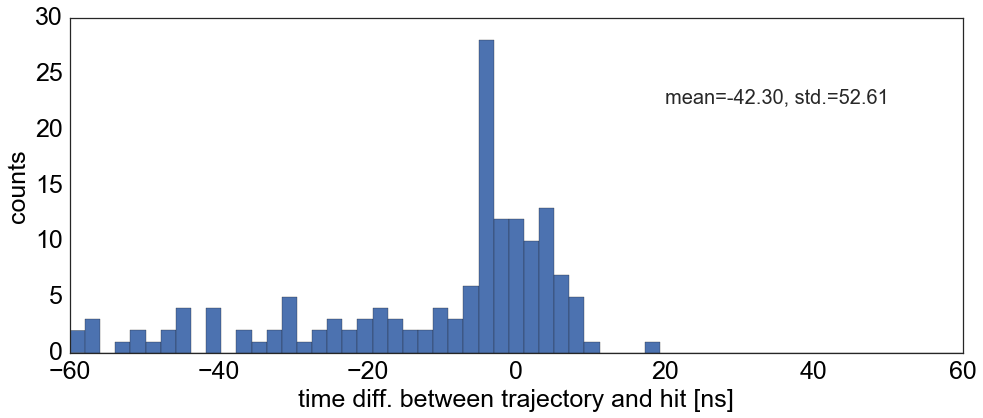

In [7]:
hits, tracks = get_event_from_rse(  events=events, run=7 , subrun=146 , event=2903 )
associate_hits_to_tracks(hits,tracks,MCmode=True)

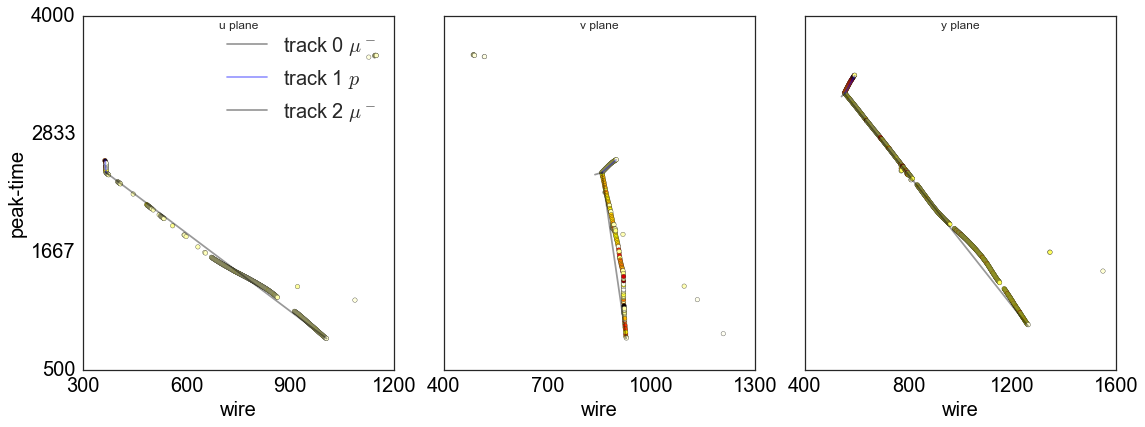

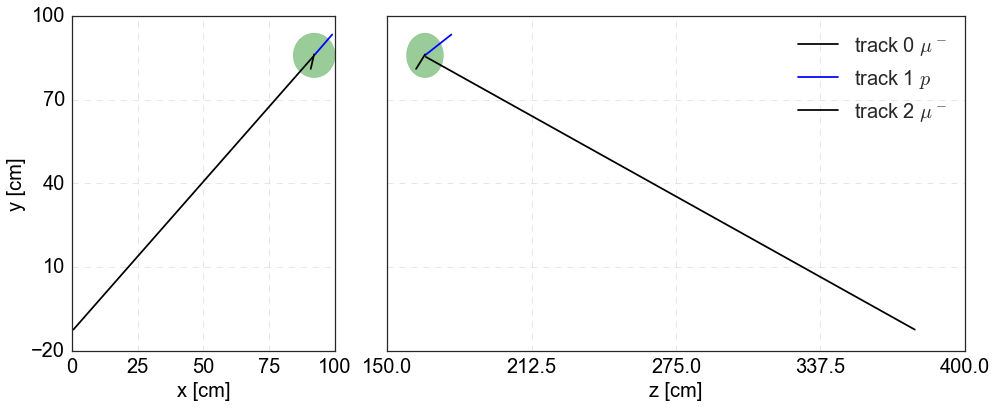

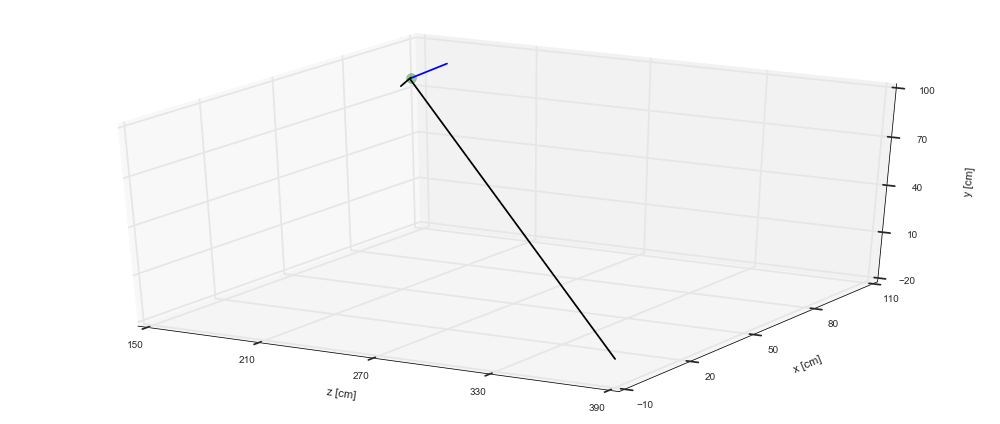

In [6]:
hits, tracks = get_event_from_rse(  events=events, run=5 , subrun=6984 , event=139673 )
draw_evd_tracks(hits,tracks,do_spatial_view=True,vertex_x=[92.195],vertex_y=[85.8901],vertex_z=[166.344])

tracks.size(): 3
hits.size(): 1012


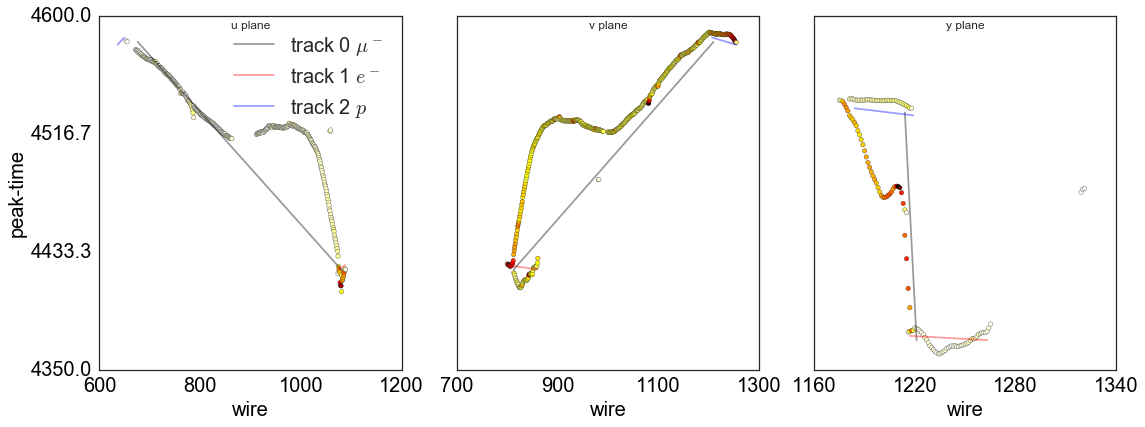

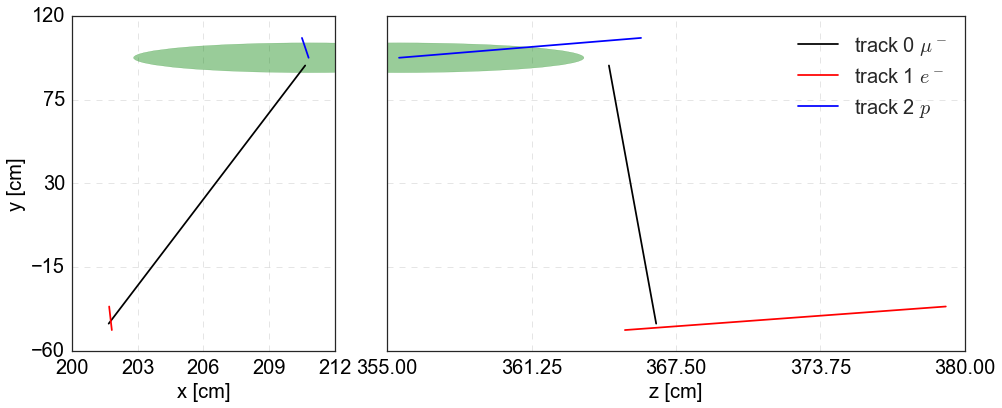

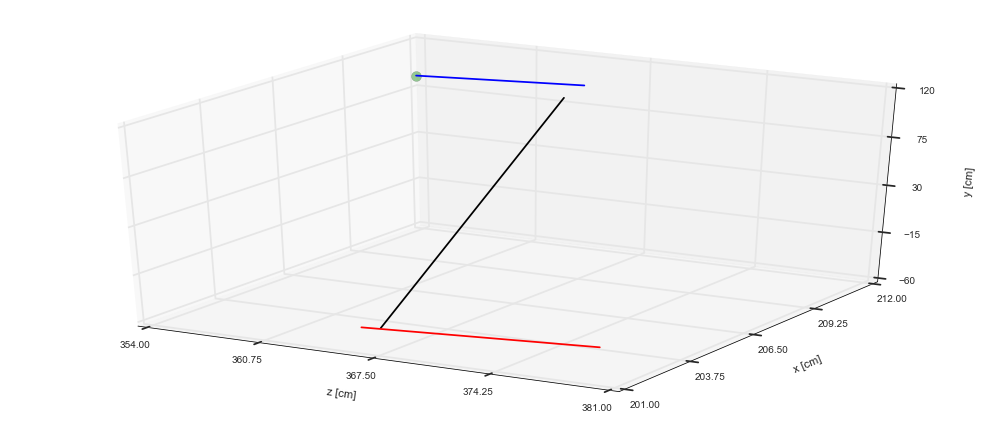

In [94]:
hits, tracks = get_event_from_rse(  events=events, run=5 , subrun=1507 , event=30127 )
draw_evd_tracks(hits,tracks,do_spatial_view=True,vertex_x=[210.809],vertex_y=[97.5536],vertex_z=[355.513])